In [1]:
import os
files=os.listdir("../input/g2net-gravitational-wave-detection")
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

In [2]:
import os
import sys
from PIL import Image
import cv2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
import albumentations as A

from sklearn.metrics import roc_auc_score

device="cuda"

In [3]:
def convert_image_id_2_path(image_id: str, is_train: bool = True) -> str:
    folder = "train" if is_train else "test"
    return "../input/g2net-gravitational-wave-detection/{}/{}/{}/{}/{}.npy".format(
        folder, image_id[0], image_id[1], image_id[2], image_id 
    )

In [4]:
train = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
train["path"]=train["id"].apply(lambda x: convert_image_id_2_path(x))
display(train)

,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
1,00001f4945,0,../input/g2net-gravitational-wave-detection/tr...
2,0000661522,0,../input/g2net-gravitational-wave-detection/tr...
3,00007a006a,0,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...
...,...,...,...
559995,ffff9a5645,1,../input/g2net-gravitational-wave-detection/tr...
559996,ffffab0c27,0,../input/g2net-gravitational-wave-detection/tr...
559997,ffffcf161a,1,../input/g2net-gravitational-wave-detection/tr...
559998,ffffd2c403,0,../input/g2net-gravitational-wave-detection/tr...


0    280070
1    279930
Name: target, dtype: int64

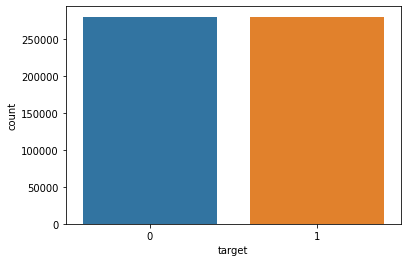

In [5]:
sns.countplot(data=train,x="target")
display(train.target.value_counts())

In [6]:
np.load(train.loc[0,"path"]).shape

(3, 4096)

In [7]:
def visualize_sample(
    _id, 
    target, 
    colors=("black", "red", "green"), 
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")
):
    path = convert_image_id_2_path(_id)
    x = np.load(path)
    plt.figure(figsize=(16, 7))
    for i in range(3):
        plt.subplot(4, 1, i + 1)
        plt.plot(x[i], color=colors[i])
        plt.legend([signal_names[i]], fontsize=12, loc="lower right")
        
        plt.subplot(4, 1, 4)
        plt.plot(x[i], color=colors[i])
    
    plt.subplot(4, 1, 4)
    plt.legend(signal_names, fontsize=12, loc="lower right")

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

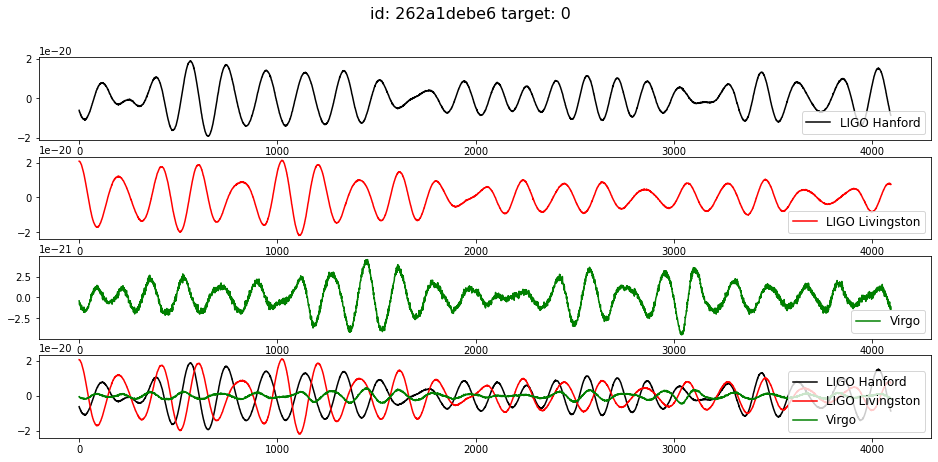

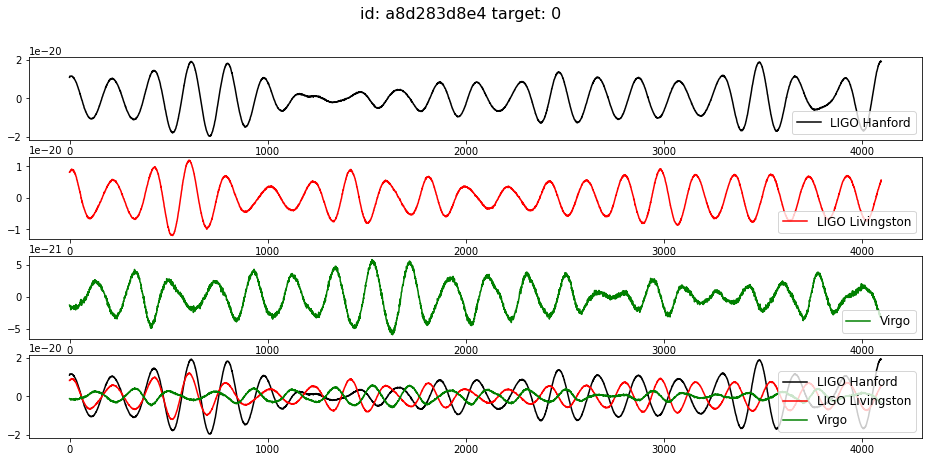

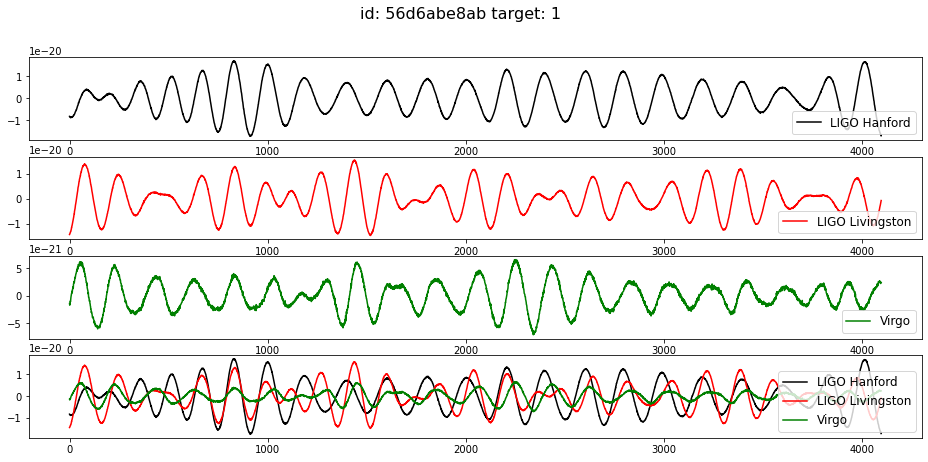

In [8]:
for i in random.sample(train.index.tolist(), 3):
    _id = train.iloc[i]["id"]
    target = train.iloc[i]["target"]

    visualize_sample(_id, target)

In [9]:
import librosa
import librosa.display

In [10]:
def visualize_sample_spectogram(
    _id, 
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")
):
    x = np.load(convert_image_id_2_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        X = librosa.stft(x[i] / x[i].max())
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.subplot(1, 3, i + 1)
        librosa.display.specshow(Xdb, sr=2048, x_axis="time", y_axis="hz", vmin=-30, vmax=50) 
        plt.colorbar()
        plt.title(signal_names[i], fontsize=14)

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

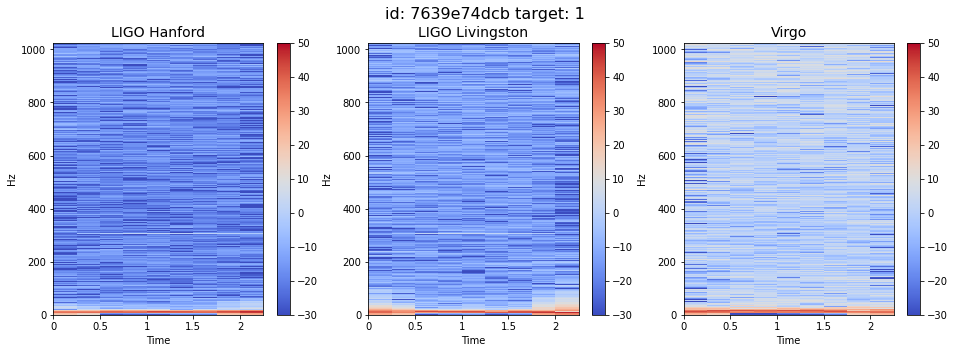

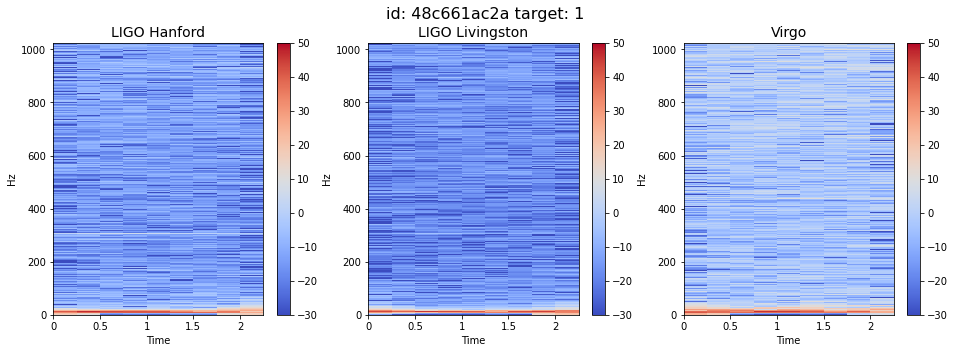

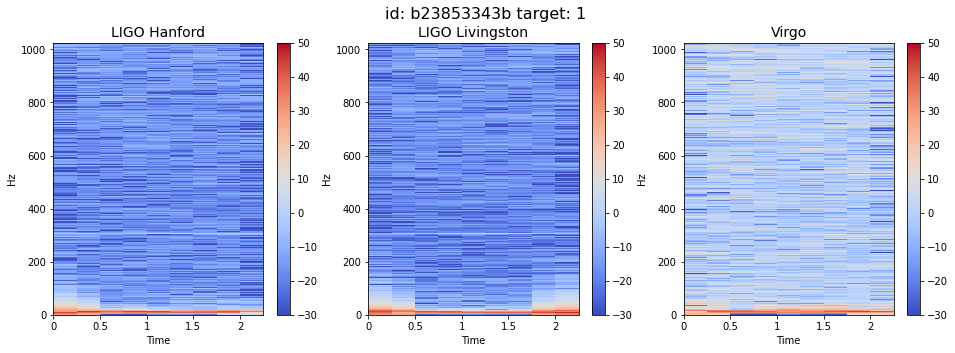

In [11]:
for i in random.sample(train.index.tolist(), 3):
    _id = train.iloc[i]["id"]
    target = train.iloc[i]["target"]

    visualize_sample_spectogram(_id, target)

In [12]:
def visualize_sample_mfcc(
    _id, 
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"),
    sr=2048,
):
    x = np.load(convert_image_id_2_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        mfccs = librosa.feature.mfcc(x[i] / x[i].max(), sr=sr)
        plt.subplot(1, 3, i + 1)
        librosa.display.specshow(mfccs, sr=sr, x_axis="time", vmin=-200, vmax=50, cmap="coolwarm")
        plt.title(signal_names[i], fontsize=14)
        plt.colorbar()

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

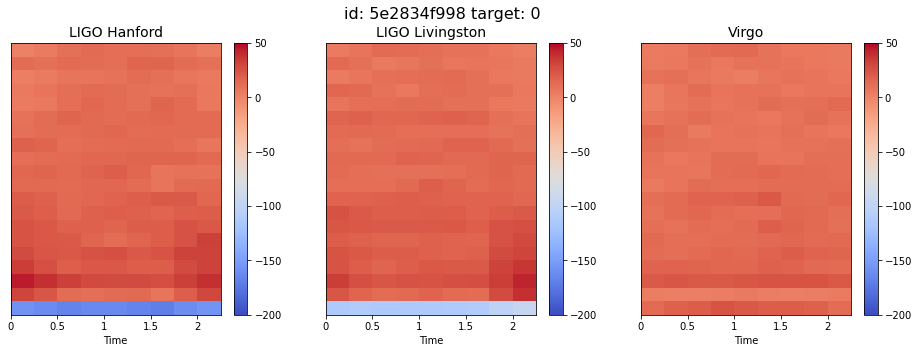

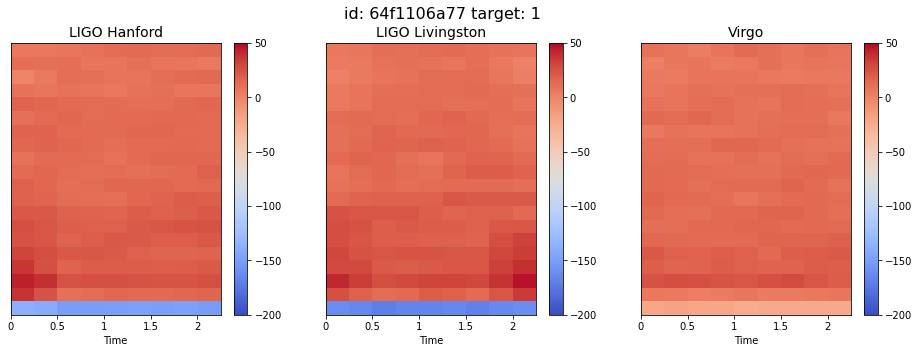

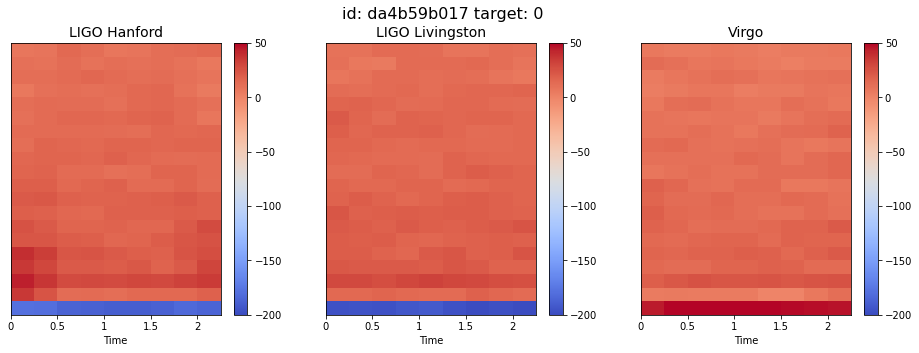

In [13]:
for i in random.sample(train.index.tolist(), 3):
    _id = train.iloc[i]["id"]
    target = train.iloc[i]["target"]

    visualize_sample_mfcc(_id, target)

In [14]:
!pip install -q nnAudio -qq
import torch
from nnAudio.Spectrogram import CQT1992v2

/opt/conda/lib/python3.7/site-packages/nnAudio/Spectrogram.py:7: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  category=Warning,


In [15]:
Q_TRANSFORM = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=32)

def visualize_sample_qtransform(
    _id, 
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"),
    sr=2048,
):
    x = np.load(convert_image_id_2_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        waves = x[i] / np.max(x[i])
        waves = torch.from_numpy(waves).float()
        image = Q_TRANSFORM(waves)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(image.squeeze())
        plt.title(signal_names[i], fontsize=14)

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

CQT kernels created, time used = 0.0376 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:408: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


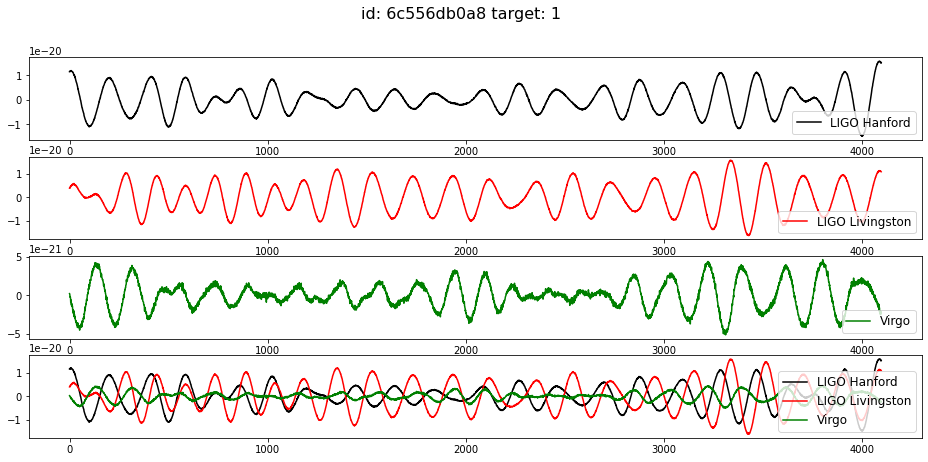

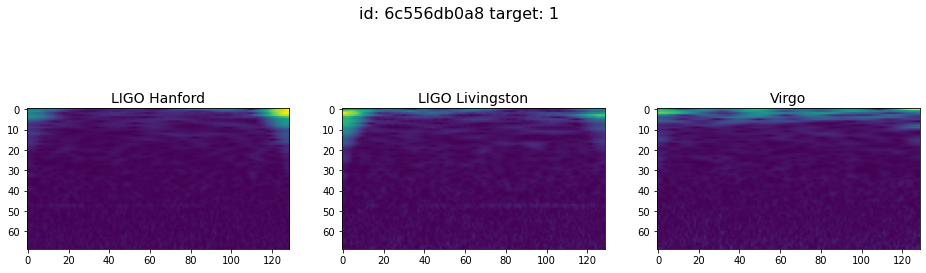

In [16]:
for i in random.sample(train.index.tolist(), 1):
    _id = train.iloc[i]["id"]
    target = train.iloc[i]["target"]

    visualize_sample(_id, target)
    visualize_sample_qtransform(_id, target)

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

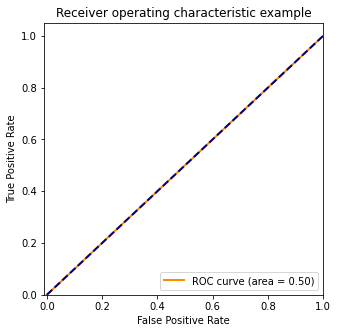

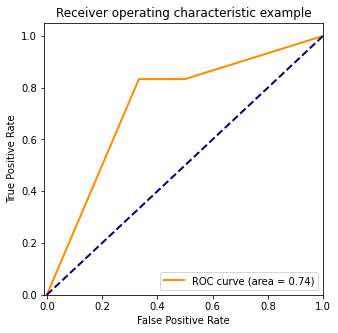

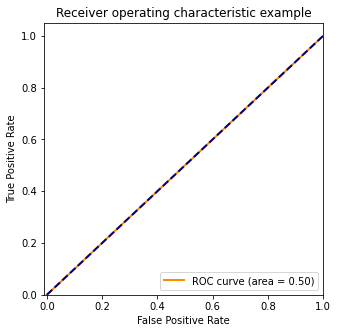

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
list_y_true = [
    [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.], #  IMBALANCE
]
list_y_pred = [
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.9, 0.9, 0.9, 0.9, 0.1, 0.9, 0.9, 0.1, 0.9, 0.1, 0.1, 0.5],
    [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], #  IMBALANCE
]

for y_true, y_pred in zip(list_y_true, list_y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# Data

In [19]:
import random
import os
def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(42)

In [20]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=5)
train["fold"]=-1
X=train.sample(frac=1.)
y=train.target
for i,(_,val_idx) in enumerate(skf.split(X,y)):
    train.loc[val_idx,"fold"]=i 

# DataLoader

In [21]:
class G2Dataset(Dataset):
    def __init__(self, df, transform=None, conf=None):
        self.df = df.reset_index(drop=True)
        self.labels = df['target'].values
        self.dir_names = df['path'].values
        self.transform = transform
        self.conf = conf
        
        self.q_transform = CQT1992v2(
            sr=2048, fmin=20, fmax=1024, hop_length=32
        )        
        
    def __len__(self):
        return len(self.df)
    
    def __get_qtransform(self, x):
        image = []
        for i in range(3):
            waves = x[i] / np.max(x[i])
            waves = torch.from_numpy(waves).float()
            channel = self.q_transform(waves).squeeze().numpy()
            image.append(channel)
            
        return image
    
    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id']
        file_path = self.df.loc[idx,"path"]
        
        image = np.load(file_path)
        image = self.__get_qtransform(image)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        image = torch.tensor(image,dtype=torch.float32)
        label = torch.tensor([self.labels[idx]]).float()
        
        return {
            "x":image, 
            "y":label
        }

In [22]:
#dataset test
fold=0
train_df=train[train.fold!=fold].reset_index(drop=True)
valid_df=train[train.fold==fold].reset_index(drop=True)

In [23]:
train_dataset=G2Dataset(train_df)
valid_dataset=G2Dataset(valid_df)

CQT kernels created, time used = 0.0174 seconds
CQT kernels created, time used = 0.0139 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:408: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [24]:
train_dataset[0]["x"].shape

torch.Size([3, 69, 129])

In [25]:
#data loader
train_loader=torch.utils.data.DataLoader(
    train_dataset,batch_size=32,num_workers=4,shuffle=True
)
valid_loader=torch.utils.data.DataLoader(
    valid_dataset,batch_size=32,num_workers=4,shuffle=False
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
for a in train_loader:
    print(a["x"].shape, a["y"].shape)
    break

torch.Size([32, 3, 69, 129]) torch.Size([32, 1])


# Model

In [27]:
class CFG:
    frac=1.0 #1.0#
    train=False#
    pretrained=True #False#
    model= "tf_efficientnet_b4"#"resnet18"#"tf_efficientnet_b4"#"R34"#"E4"#
    train_bs=1024
    valid_bs=128#12
    test_bs=128
    epochs=4
    fold=[0,1,2]
    classes=1
    seed= 719
    lr=2e-4
    es=4

In [28]:
## Model
import torch
import torch.nn as nn
import torchvision

def get_model(classes=1,pretrained=True):
    classes=classes
    base_model=timm.create_model(CFG.model, pretrained=pretrained,num_classes=1)
    return base_model 

In [29]:
model=get_model()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_aa-818f208c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_aa-818f208c.pth


In [30]:
# device="cuda"
# model.to(device)
# model.train()

# for a in train_loader:
#     x=a["x"].to(device)
#     y=a["y"].to(device)
#     output=model(x)
#     break

# output.squeeze(-1).shape

# Train Function

In [31]:
def loss_fn(outputs,targets):
    return nn.BCEWithLogitsLoss()(outputs,targets)

In [32]:
## Engine
from tqdm import tqdm
class Engine:
    def __init__(self,model,optimizer,scheduler=None):
        self.model=model
        self.optimizer=optimizer
        self.scheduler=scheduler
        self.device="cuda"

    def train(self,data_loader):
        self.model.train()
        final_loss=0
        for data in tqdm(data_loader):
            self.optimizer.zero_grad()
            inputs=data["x"].to(self.device)
            targets=data["y"].to(self.device)
            outputs=self.model(inputs)
            loss=loss_fn(outputs,targets)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
        return final_loss/len(data_loader)
    
    def validate(self,data_loader):
        self.model.eval()
        final_loss=0
        for data in tqdm(data_loader):
            inputs=data["x"].to(self.device)
            targets=data["y"].to(self.device)
            outputs=self.model(inputs)
            loss=loss_fn(outputs,targets)
            final_loss += loss.item()
        return final_loss/len(data_loader)

In [33]:
def get_dataset(fold=0):
    train_df=train[train.fold!=fold].reset_index(drop=True).sample(frac=1.0)
    valid_df=train[train.fold==fold].reset_index(drop=True).sample(frac=1.0)

    train_dataset=G2Dataset(train_df)
    valid_dataset=G2Dataset(valid_df)

    train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=CFG.train_bs,num_workers=4,shuffle=True)
    valid_loader=torch.utils.data.DataLoader(valid_dataset,batch_size=CFG.valid_bs,num_workers=4,shuffle=False)
    return train_loader,valid_loader

In [34]:
def loop_train(fold,save_model=False):
    # Dataset
    train_loader,valid_loader=get_dataset(fold)
    model=get_model()
    model.to("cuda")

    # Model,Optimizer, scheduler, engine
    optimizer=torch.optim.Adam(model.parameters(),lr=3e-4)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,patience=3,threshold=1e-5,mode="min",verbose=True)
    engine=Engine(model,optimizer,scheduler)
    best_loss=np.inf
    early_stopping=10
    early_stopping_cnt=0
    EPOCH=300
    for epoch in range(EPOCH):
        train_loss=engine.train(train_loader)
        valid_loss=engine.validate(valid_loader)
        scheduler.step(valid_loss)

        if valid_loss<best_loss:
            best_loss=valid_loss
            torch.save(model.state_dict(),f"model_{CFG.model}_fold_{fold}.bin")
            print(f"fold={fold}, epoch={epoch}, train_loss={train_loss:.6f}, valid_loss={valid_loss:.6f}")    
            early_stopping_cnt=0
        else:
            early_stopping_cnt+=1
        if early_stopping_cnt>early_stopping:
            break

    print(f"fold={fold}, best val loss={best_loss}")

In [35]:
if CFG.train:
    loop_train(0,save_model=True)

# Predict

In [36]:
test = pd.read_csv("../input/g2net-gravitational-wave-detection/sample_submission.csv")
test["path"]=test["id"].apply(lambda x: convert_image_id_2_path(x,False))

In [37]:
def get_dataset_test():
    test_dataset=G2Dataset(test)
    test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=CFG.test_bs,num_workers=4,shuffle=False)
    return test_loader

In [38]:
def predict(model,dataloader):
    all_preds=[]
    model.to(device)
    model.eval()
    preds=[]
        
    with torch.no_grad():
        for data in tqdm(dataloader):
            inputs=data["x"].to(device)
            outputs=model(inputs)
            outputs=outputs.squeeze(-1)
            preds.append(outputs.cpu().detach().numpy())
        preds=np.concatenate(preds)
        all_preds.append(preds)

    return all_preds

In [39]:
data_loader=get_dataset_test()
model=get_model()
path="../input/g2-efficientnet-e4/model_fold_0_g2_211211.bin"#f"./model_{CFG.model}_fold_0.bin"
model.load_state_dict(torch.load(path))

preds=predict(model,data_loader)

CQT kernels created, time used = 0.0150 seconds


100%|██████████| 1766/1766 [50:08<00:00,  1.70s/it] 


In [45]:
test["target"]=np.squeeze(np.array(preds))
test[["id","target"]].to_csv("submission.csv",index=False)
test.head()

,id,target,path
0,00005bced6,9.121670,../input/g2net-gravitational-wave-detection/te...
1,0000806717,4.271601,../input/g2net-gravitational-wave-detection/te...
2,0000ef4fe1,-0.894144,../input/g2net-gravitational-wave-detection/te...
3,00020de251,-0.341169,../input/g2net-gravitational-wave-detection/te...
4,00024887b5,-2.110984,../input/g2net-gravitational-wave-detection/te...


In [44]:
np.squeeze(np.array(preds)).shape

(226000,)

In [ ]:
test